In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

In [2]:
bank = pd.read_csv('/content/banking_messages_15000.csv')
bank.head()

,text,label
0,Fantastic customer support. please help,complement
1,"Dear Bank, Please issue me a new cheque book. ...",request
2,"Respected Team, I am happy with your banking s...",complement
3,"Hello, How do I activate internet banking? kin...",service
4,"Hello, Send me details of my recent transactio...",request


In [3]:
def preprocess_text(text):
  bank_tokens = word_tokenize(text.lower())
  bank_filtered = [word for word in bank_tokens if word not in stopwords.words('english')]
  bank_lemmatized = [WordNetLemmatizer().lemmatize(word) for word in bank_filtered]
  preprocessed_text = ' '.join(bank_lemmatized)
  return preprocessed_text

In [4]:
bank['text'] = bank['text'].apply(preprocess_text)

In [5]:
def sentiment_analysis(text):
  sid = SentimentIntensityAnalyzer()
  sentiment_scores = sid.polarity_scores(text)
  return sentiment_scores

In [6]:
bank['sentiment_scores'] = bank['text'].apply(sentiment_analysis)
bank.head()

,text,label,sentiment_scores
0,fantastic customer support . please help,complement,"{'neg': 0.0, 'neu': 0.081, 'pos': 0.919, 'comp..."
1,"dear bank , please issue new cheque book . regard",request,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou..."
2,"respected team , happy banking service . asap",complement,"{'neg': 0.0, 'neu': 0.37, 'pos': 0.63, 'compou..."
3,"hello , activate internet banking ? kindly asa...",service,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp..."
4,"hello , send detail recent transaction please .",request,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp..."


In [7]:
label_encoder = LabelEncoder()

bank['encoded_label'] = label_encoder.fit_transform(bank['label'])

print("Original Labels vs. Encoded Labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

bank.head()

Original Labels vs. Encoded Labels:
complaint: 0
complement: 1
request: 2
service: 3


,text,label,sentiment_scores,encoded_label
0,fantastic customer support . please help,complement,"{'neg': 0.0, 'neu': 0.081, 'pos': 0.919, 'comp...",1
1,"dear bank , please issue new cheque book . regard",request,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou...",2
2,"respected team , happy banking service . asap",complement,"{'neg': 0.0, 'neu': 0.37, 'pos': 0.63, 'compou...",1
3,"hello , activate internet banking ? kindly asa...",service,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp...",3
4,"hello , send detail recent transaction please .",request,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",2


In [8]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectors = tfidf_vectorizer.fit_transform(bank['text'])

print("TF-IDF vectors created with shape:", tfidf_vectors.shape)

TF-IDF vectors created with shape: (15000, 141)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, bank['encoded_label'], test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (12000, 141)
X_test shape: (3000, 141)
y_train shape: (12000,)
y_test shape: (3000,)


In [10]:
multi_class_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

multi_class_model.fit(X_train, y_train)

print("Multi-class Logistic Regression model trained successfully.")

Multi-class Logistic Regression model trained successfully.


Classification Report:
              precision    recall  f1-score   support

   complaint       1.00      1.00      1.00       747
  complement       1.00      1.00      1.00       758
     request       0.99      1.00      1.00       738
     service       1.00      0.99      1.00       757

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



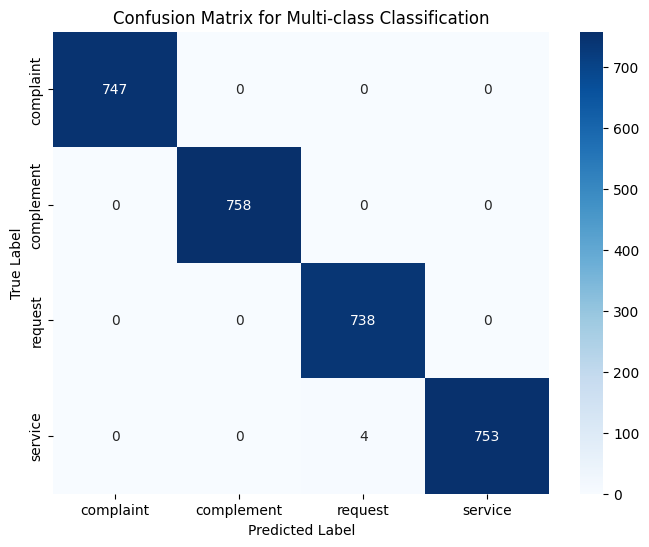

In [11]:
y_pred = multi_class_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Multi-class Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
def gradio_interface_multi_class(text):
  preprocessed_text = preprocess_text(text)
  vectorized_text = tfidf_vectorizer.transform([preprocessed_text])
  predicted_encoded_label = multi_class_model.predict(vectorized_text)
  predicted_label = label_encoder.inverse_transform(predicted_encoded_label)
  return predicted_label[0]

bank_demo_multi_class = gr.Interface(fn=gradio_interface_multi_class, inputs="text", outputs="text")

bank_demo_multi_class.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://01279e9b60ec9e9fd0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
